 Source: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

 Modified and used under MIT License


neural network classification with pytorch

1.Make classification data and get it ready

The make_circles() function from sklearn.datasets is used to generate a synthetic dataset specifically designed for binary classification problems. It creates a set of 2D coordinates (X), where each point is represented as an (x, y) pair. These coordinates are generated in such a way that when plotted, they form two concentric circular patterns — one smaller inner circle and one larger outer circle.

Each point is calculated using the parametric equations of a circle:

x = r * cos(θ)

y = r * sin(θ)

Here, θ (theta) is an angle that ranges evenly between 0 and 2π radians (i.e., 0 to 360°), and r is the radius of the circle. The inner circle is generated using a smaller radius (e.g., 0.5), and the outer circle using a larger one (e.g., 1.0). Both circles are created using the same set of θ values, so the points are uniformly spread in a circular shape.
The inner circle’s radius can be controlled using the factor parameter (e.g., factor=0.3 makes the inner circle smaller than the default).

Labels are also assigned at the time of dataset creation. Points belonging to the outer circle are labeled as class 0, and points in the inner circle are labeled as class 1. Since this is a classification task and classification is a form of supervised learning, the model is trained using both the input data (X) and the corresponding labels (y). The model doesn't decide labels on its own — it learns patterns based on the labeled data provided during training.

Additionally, a small amount of noise can be added using the noise parameter. This makes the circular boundary slightly imperfect, making the classification task more realistic and challenging for the model.

After training, the model should be able to take a new (x, y) point and predict whether it belongs to the inner or outer circle by applying the pattern it has learned — this is known as generalization.



In [89]:
import sklearn
from sklearn.datasets import make_circles
#make 1000 samples
n_samples=1000
#create circles
X,y=make_circles(n_samples,
                 noise=0.03,
                 random_state=42
                 )
len(X),len(y)

(1000, 1000)

In [90]:
#2 features of X and 1 label of y(0 or 1)
print(f"first 5 samples of x {X[:5]}")
print(f"first 5 samples of y {y[:5]} ")

first 5 samples of x [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
first 5 samples of y [1 1 1 1 0] 


Array (X of shape = (1000, 2))

| Expression        | Returns                      | Meaning                          |
|------------------|------------------------------|----------------------------------|
| `X[:, 0]`         | 1D array of x-values          | All rows and Only first column                |
| `X[:, 1]`         | 1D array of y-values          | All rows and Only second column               |
| `X[:, 0:2]`       | 2D array of x and y values    |All rows and  Both columns (0 and 1)           |
| `X[:, :]`         | Entire array                 | All rows and all columns         |
| `X[:, [0, 1]]`    | Same as `X[:, 0:2]`           | Both columns using list indexing |


In [91]:
#make dataframes of circle data
import pandas as pd
circles=pd.DataFrame({"X1":X[:,0],
                      "X2":X[:,1],
                     "label":y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [92]:
circles.label.value_counts()    # we have a balanced dataset

,count
label,
1,500
0,500


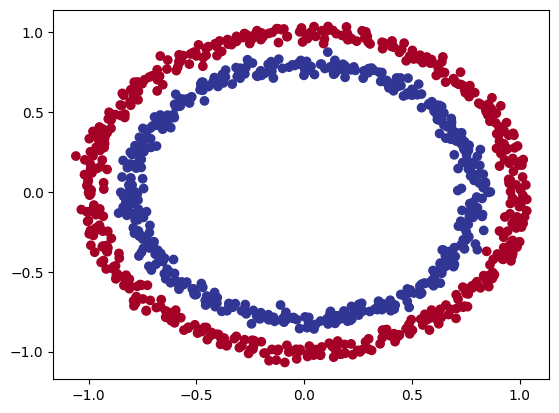

In [93]:
#visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu
            )
plt.show()

note: The data we are working with is often reffered as toy dataset, a dataset is small enough to experiment but still sizeable enough to practice the fundamentals.

In [94]:
#check input and output shape
X.shape,y.shape

((1000, 2), (1000,))

In [95]:
#view the first example of features and labels
X_sample=X[0]
y_sample=y[0]
print(f"values for one sample of  x: {X_sample}")
print(f"values for one sample of y: {y_sample}")
print(f"shape for one sample of  x: {X_sample.shape}")  #1d array with no rows/columns distinction . it has only 1 dimension
print(f"shape for one sample of y: {y_sample.shape}")   #No rows, no columns,Just a scalar. hence ,shape is empty tuple ()




values for one sample of  x: [0.75424625 0.23148074]
values for one sample of y: 1
shape for one sample of  x: (2,)
shape for one sample of y: ()


In [96]:
type(X),X.dtype   #numpy default is float 64 where for pytorch its float 32

(numpy.ndarray, dtype('float64'))

In [97]:
#turn data into tensors
import torch
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)


In [98]:
print(X[:5],y[:5])
X.dtype,y.dtype

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]]) tensor([1., 1., 1., 1., 0.])


(torch.float32, torch.float32)

In [99]:
#create train and test split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,
                                               y,
                                               test_size=0.2,
                                               random_state=42)
len(X_train),len(X_test),len(y_train),len(y_test)

(800, 200, 800, 200)

2.Building a model

to classify blue and red dots.

->setup device aagnostic code so our code run on GPU if there is one

->construct a model(by subclassing nn.Modeule)

->define loss function and optimizer

->creating a training and testing loop

In [100]:
import torch
from torch import nn
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

->subclass nn.Module

->create two nn.linear(),layers that are capable of handling the shapes of our data

->define a forward() method that outlines the forward pass of the model

->instatiate an instance of model and send it to target device


In [101]:
X_train.shape

torch.Size([800, 2])



We are training a simple neural network with:

* **Input**: 2 features (x1, x2)
* **Hidden Layer**: 5 neurons
* **Output Layer**: 1 neuron (for binary classification)

---

 🔢 Forward Pass (Prediction Step)

Each layer applies this transformation:

$$
 z = x \cdot W^T + b
$$

Where:

* $x$ is the input vector
* $W$ are the weights
* $b$ is the bias term

**Layer 1 (Hidden Layer)**:
If input $x = [x_1, x_2]$, then hidden neurons compute:

$$
\begin{aligned}
  z_1 &= x_1 \cdot w_{11} + x_2 \cdot w_{12} + b_1 \\
  z_2 &= x_1 \cdot w_{21} + x_2 \cdot w_{22} + b_2 \\
  &\vdots \\
  z_5 &= x_1 \cdot w_{51} + x_2 \cdot w_{52} + b_5
\end{aligned}
$$

Then, these z-values are passed through activation function (e.g., ReLU or sigmoid) to get $a_1, a_2, ..., a_5$.

**Layer 2 (Output Layer)**:

$$
 y_{\text{pred}} = z_1 \cdot w_1 + z_2 \cdot w_2 + ... + z_5 \cdot w_5 + b
$$

So total flow:

$$
\text{Input (x)} \rightarrow \text{Hidden Layer (5 features)} \rightarrow \text{Output (1 value)}
$$

---

 📉 Loss Calculation (Binary Classification)

To measure error:

$$
\text{Loss} = -[y \cdot \log(y_{\text{pred}}) + (1 - y) \cdot \log(1 - y_{\text{pred}})]
$$

Where:

* $y$ is the true label (0 or 1)
* $y_{\text{pred}}$ is the predicted output

---

 🔄 Backpropagation (Gradient Flow)

Now we calculate how to update weights to reduce loss. We compute gradients:

$$
\text{Gradient} = \frac{\partial \text{Loss}}{\partial \text{Weight}}
$$

This tells us: "If I slightly change this weight, how does the loss change?"

 ✅ Step 1: Output Layer (Layer 2)

We apply chain rule:

$$
\frac{\partial \text{Loss}}{\partial W_2} =
\frac{\partial \text{Loss}}{\partial y_{\text{pred}}}
\cdot \frac{\partial y_{\text{pred}}}{\partial z_2}
\cdot \frac{\partial z_2}{\partial W_2}
$$

This tells us how layer 2's weights contributed to the error.

 ✅ Step 2: Hidden Layer (Layer 1)

Now apply chain rule again:

$$
\frac{\partial \text{Loss}}{\partial W_1} =
\frac{\partial \text{Loss}}{\partial z_2}
\cdot \frac{\partial z_2}{\partial a_1}
\cdot \frac{\partial a_1}{\partial z_1}
\cdot \frac{\partial z_1}{\partial W_1}
$$

Where:

* $a_1$ = activated outputs of hidden layer
* $z_1$ = pre-activation outputs of hidden layer

This tells us how layer 1's weights contributed to the loss.

 📌 What are W₁ and W₂ in a Neural Network?

In a neural network:

🔹 **W₁** — Weights of the first (hidden) layer  
- These connect input features (like `x₁`, `x₂`) to each neuron in the hidden layer.  
- If there are 2 input features and 5 hidden neurons, then `W₁` is a **(5 × 2)** matrix.

🔹 **W₂** — Weights of the second (output) layer  
- These connect the hidden layer outputs (`z₁`, `z₂`, ..., `z₅`) to the final output neuron.  
- If the hidden layer has 5 neurons and output is a single value, then `W₂` is a **(1 × 5)** matrix.




✅ Step 3: Input Layer

The gradient flows back to inputs $x_1, x_2$ (not updated since inputs are not trainable).

---

📊 Optimizer Step (Update Weights)

Once gradients are known, the optimizer updates each weight:

$$
\text{new_weight} = \text{old_weight} - \text{learning_rate} \cdot \frac{\partial \text{Loss}}{\partial \text{Weight}}
$$

* If gradient is $+$, weight is decreased
* If gradient is $-$, weight is increased

Optimizers like SGD or Adam use this rule — they don’t "think", they just follow the math.

---

⏲ Training Loop (Epochs)

Each iteration does:

1. **Forward Pass** — compute prediction
2. **Loss Calculation** — how wrong is it?
3. **Backward Pass** — flow gradients backward
4. **Optimizer Step** — update weights

Repeat this loop many times until the loss is minimized.

---

 ✅ Key Understandings:

* Gradients help decide weight direction to reduce error
* Backpropagation applies chain rule layer by layer
* Optimizer updates weights using those gradients
* Training loop repeats till prediction becomes accurate



In [102]:
class circleModelv0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1=nn.Linear(in_features=2,out_features=5)  #takes in 2 features and upscale to 5 features
    self.layer_2=nn.Linear(in_features=5,out_features=1)   #takes 5 features from previos layer and output single feature(same shape as y)

  def forward(self,x):
    return self.layer_2(self.layer_1(x))  # x -> layer1 -> layer2

model_0=circleModelv0().to(device)
model_0


circleModelv0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [103]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.4830, -0.5999],
                      [-0.3894, -0.6189],
                      [-0.4502,  0.7068],
                      [ 0.1336,  0.2179],
                      [-0.6595, -0.4644]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.2354,  0.1106, -0.6222, -0.3047, -0.4233], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.0012, -0.1664, -0.0310, -0.3030, -0.3070]], device='cuda:0')),
             ('layer_2.bias', tensor([-0.2609], device='cuda:0'))])

In [104]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [105]:
#next replicate the model above using nn.Sequential()
mmodel_0=nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)

model_0

circleModelv0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [106]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.4830, -0.5999],
                      [-0.3894, -0.6189],
                      [-0.4502,  0.7068],
                      [ 0.1336,  0.2179],
                      [-0.6595, -0.4644]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.2354,  0.1106, -0.6222, -0.3047, -0.4233], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.0012, -0.1664, -0.0310, -0.3030, -0.3070]], device='cuda:0')),
             ('layer_2.bias', tensor([-0.2609], device='cuda:0'))])

In [107]:
#make predictions

with torch.inference_mode():
    untrained_preds=model_0(X_test.to(device))
print(f"the shape of prediction: {untrained_preds.shape}, and length of prediction :{len(untrained_preds)}")
print(f"the shape of test labels: {y_test.shape}, and length of test labels :{len(y_test)}")

print(torch.round(untrained_preds[:10]))
print(y_test[:10])


the shape of prediction: torch.Size([200, 1]), and length of prediction :200
the shape of test labels: torch.Size([200]), and length of test labels :200
tensor([[-0.],
        [0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [-0.],
        [0.]], device='cuda:0')
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


"logit" is raw output of a model before applying an activation function like Sigmoid or Softmax, especially in binary or multi-class classification problems.

📌 Understanding the Difference Between BCELoss and BCEWithLogitsLoss (PyTorch)

When you're solving a binary classification problem in PyTorch, you often need to measure how close your model's predictions are to the actual labels (which are 0 or 1).

PyTorch provides two main loss functions for this:

----------------------------------------------------
🔸 1. BCELoss (Binary Cross Entropy Loss)
----------------------------------------------------
- This loss function expects the model's output to already be a probability between 0 and 1.
- So, you need to manually apply a sigmoid activation function to your model’s output before passing it to this loss.
- It's calculated using the formula:

    BCE = -[ y * log(p) + (1 - y) * log(1 - p) ]

  where:
    - y is the actual label (0 or 1)
    - p is the predicted probability (after sigmoid)

- The major downside is: it's **numerically unstable** when the predicted values are very close to 0 or 1 (can cause overflow or NaNs).
- That’s why this method is not recommended in real-world deep learning training.

----------------------------------------------------
🟢 2. BCEWithLogitsLoss
----------------------------------------------------
- This loss function expects the model’s output to be raw — that is, without applying any sigmoid.
- It automatically applies the sigmoid function **internally**, and then computes the Binary Cross Entropy loss.
- PyTorch uses a more stable mathematical trick to avoid issues like overflow or underflow in the sigmoid+log calculation.
- This makes it much more reliable, especially when training deep models or using large values.
- This is the **recommended loss function** for binary classification in PyTorch.

----------------------------------------------------
🧠 Simple Rule of Thumb:

- If your model’s output goes through a sigmoid before the loss, use ➤ `BCELoss`
- If your model outputs raw logits (no sigmoid), use ➤ `BCEWithLogitsLoss` ✅

Most of the time, **you should prefer `BCEWithLogitsLoss`**, because it’s faster, safer, and easier to use correctly.



In [108]:
#set up loss function and optimizer
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(params=model_0.parameters(),
                          lr=0.1)

In [109]:
#calculate accuracy= out of 100 examples,what percentage does our model gets right?
#acc=TP+TN/TP+TN+FP+FN
def accuracy_fn(y_true,y_pred):
  correct=torch.eq(y_true,y_pred).sum().item()
  acc=correct/len(y_pred) * 100
  return acc



going from raw logits ->prediction probabilities ->prediction labels

our model output are going to be raw **Logits**

we can convert these logits into prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification)

then we can convert our prediction probabilities to prediction labels by either rounding them or taking the argmax()

In [110]:
#view the first 5 output of the forward pass on test data
with torch.inference_mode():
  y_logits=model_0(X_test.to(device))[:5]
y_logits


tensor([[-0.0210],
        [ 0.1162],
        [-0.2562],
        [ 0.0451],
        [-0.0581]], device='cuda:0')

In [111]:
#but Y_test are in form 0 and 1
#use the sigmoid activation function on our model logits into prediction probabilities
y_pred_probs=torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4947],
        [0.5290],
        [0.4363],
        [0.5113],
        [0.4855]], device='cuda:0')

In [112]:
y_preds=torch.round(y_pred_probs)
y_preds

tensor([[0.],
        [1.],
        [0.],
        [1.],
        [0.]], device='cuda:0')

for our prediction probabilities value. we need to to perform range-style rounding on them:
y_pred_probs >=0.5 "y=1"

y_pred_probs< 0.5 "y=0

we can change the decision boundary values

In [113]:
with torch.inference_mode():
  y_pred_label=torch.round(torch.sigmoid(model_0(X_test.to(device))))
y_pred_label
print(torch.eq(y_preds.squeeze(),y_pred_label.squeeze()[:5]))
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 1., 0., 1., 0.], device='cuda:0')

In [114]:
torch.manual_seed(42)
epochs=1000
X_train=X_train.to(device)
X_test=X_test.to(device)
y_train=y_train.to(device)
y_test=y_test.to(device)

for epoch in range(epochs):
  model_0.train()
  y_logits=model_0(X_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits))
  loss=loss_fn(y_logits,y_train)
  acc=accuracy_fn(y_true=y_train,y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    test_logits=model_0(X_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))


    test_loss=loss_fn(test_logits,y_test)
    test_acc=accuracy_fn(y_true=y_test,y_pred=test_pred)

  if epoch%100==0:
    print(f"epoch no:{epoch},loss:{loss:5f},accuracy:{acc:2f}%,test loss:{test_loss:5f},test accuracy={test_acc:2f}%")





epoch no:0,loss:0.696107,accuracy:50.375000%,test loss:0.703223,test accuracy=48.000000%
epoch no:100,loss:0.693294,accuracy:49.500000%,test loss:0.695533,test accuracy=49.500000%
epoch no:200,loss:0.693057,accuracy:50.125000%,test loss:0.694756,test accuracy=49.000000%
epoch no:300,loss:0.693000,accuracy:50.625000%,test loss:0.694666,test accuracy=46.000000%
epoch no:400,loss:0.692985,accuracy:50.750000%,test loss:0.694663,test accuracy=46.000000%
epoch no:500,loss:0.692981,accuracy:51.375000%,test loss:0.694670,test accuracy=46.000000%
epoch no:600,loss:0.692980,accuracy:51.000000%,test loss:0.694674,test accuracy=45.500000%
epoch no:700,loss:0.692980,accuracy:51.250000%,test loss:0.694677,test accuracy=45.500000%
epoch no:800,loss:0.692980,accuracy:51.250000%,test loss:0.694678,test accuracy=46.000000%
epoch no:900,loss:0.692980,accuracy:51.125000%,test loss:0.694679,test accuracy=46.000000%


from the metrics its look like our model is not learning anything....

so lets's make some prediction and visualize

to do so, we are going to import a function called plot_decision_boundary

In [115]:
import requests
from pathlib import Path
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists,skipping download")
else:
  print("downloading...")
  request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
      f.write(request.content)

from helper_functions import plot_predictions,plot_decision_boundary

helper_functions.py already exists,skipping download


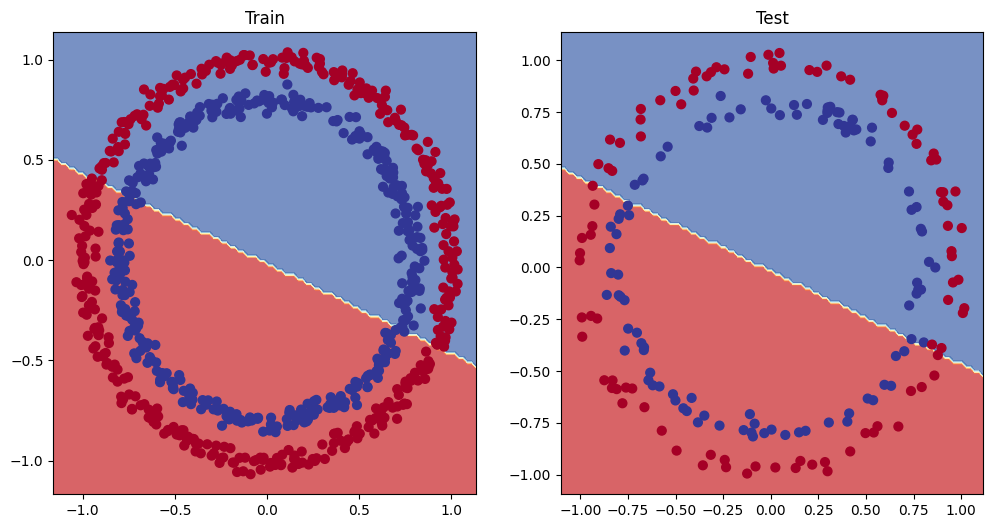

In [116]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)

Improving a model(from a model perspective)

1.Add more layers-give model more chances to learn about patterns in data

2.Add more hidden units

3.fit for longer(more epochs)

4.changing the activation function

5.change the learning rate

6.change the loss function

In [117]:
#improving through experimentation
class circleModelv1(nn.Module):
  def __init__(self):
    super().__init__()
    self.Layer_1=nn.Linear(in_features=2,out_features=10)
    self.Layer_2=nn.Linear(in_features=10,out_features=10)
    self.Layer_3=nn.Linear(in_features=10,out_features=1)

  def forward(self,x):
    return self.Layer_3(self.Layer_2(self.Layer_1(x)))

model_1=circleModelv1().to(device)

In [118]:
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(params=model_1.parameters(),lr=0.1)

In [119]:
torch.manual_seed(42)
epochs=100
X_train=X_train.to(device)
y_train=y_train.to(device)
X_test=X_test.to(device)
y_test=y_test.to(device)

for epoch in range(epochs):
    model_1.train()
    y_logits=model_1(X_train).squeeze()
    y_pred=torch.round(torch.sigmoid(y_logits))

    loss=loss_fn(y_logits,y_train)
    acc=accuracy_fn(y_true=y_train,y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
      test_logits=model_1(X_test).squeeze()
      test_pred=torch.round(torch.sigmoid(test_logits))

      test_loss=loss_fn(test_logits,y_test)
      test_acc=accuracy_fn(y_true=y_test,y_pred=test_pred)
    if epoch%100==0:
      print(f"epoch no:{epoch},loss:{loss:5f},accuracy:{acc:2f}%,test loss:{test_loss:5f},test accuracy={test_acc:2f}%")



epoch no:0,loss:0.693955,accuracy:50.875000%,test loss:0.692615,test accuracy=51.000000%


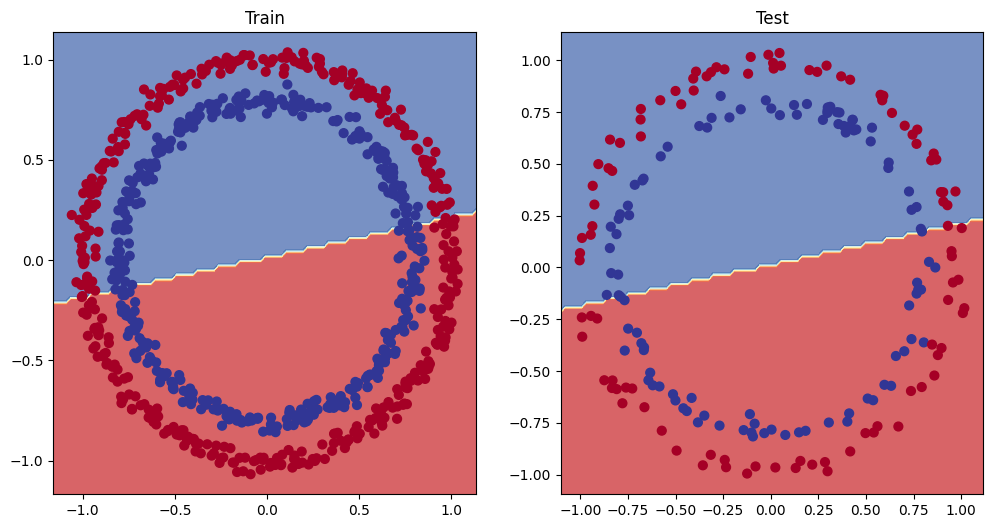

In [120]:
#plot the decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train,y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,X_test,y_test)

preparing data to see if our model can fit a staright line(checking if our model can learn anything at all)

one way to troubleshoot a alrger problem is to test out a smaller problem

In [121]:
weight=0.7
bias=0.3
start=0
end=1
step=0.01

X_regression=torch.arange(start,end,step).unsqueeze(dim=1)
y_regression =weight* X_regression + bias

print(len(X_regression))
print(len(y_regression))
print(X_regression[:5])
print(y_regression[:5])

100
100
tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400]])
tensor([[0.3000],
        [0.3070],
        [0.3140],
        [0.3210],
        [0.3280]])


In [122]:
train_split=int(0.8*len(X_regression))
X_train_regression=X_regression[:train_split]
y_train_regression=y_regression[:train_split]
X_test_regression=X_regression[train_split:]
y_test_regression=y_regression[train_split:]

print(len(X_train_regression))
print(len(y_train_regression))
print(len(X_test_regression))
print(len(y_test_regression))

80
80
20
20


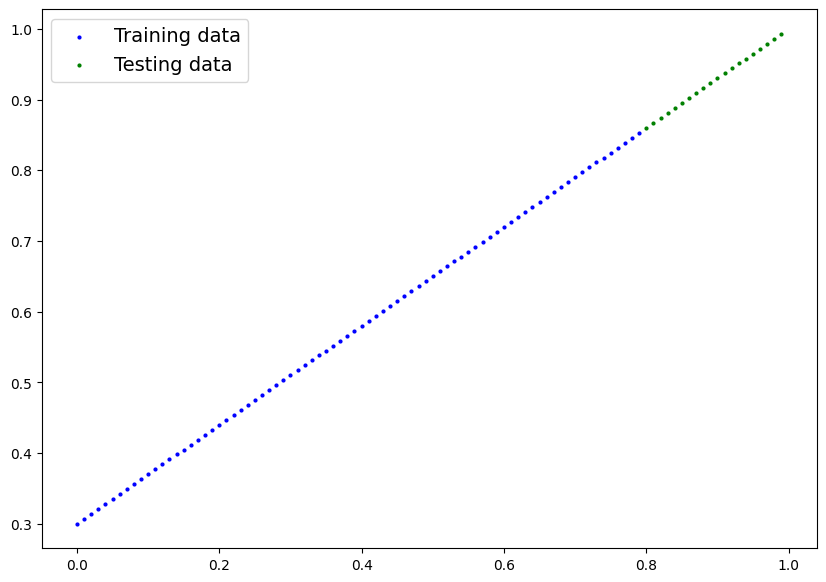

In [123]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression,
                 predictions=None)

In [124]:
#adjusting model_1 to fit a straight line
#same architecture as mode_1 but using nn.sequential
model_2=nn.Sequential(
    nn.Linear(in_features=1,out_features=10),
    nn.Linear(in_features=10,out_features=10),
    nn.Linear(in_features=10,out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [125]:
loss_fn=nn.L1Loss()
optimizer=torch.optim.SGD(params=model_2.parameters(),lr=0.01)

In [55]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 10000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  # Print out what's happenin'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986 | Test loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test loss: 0.00360
Epoch: 1000 | Loss: 0.01782 | Test loss: 0.00333
Epoch: 1100 | Loss: 0.01674 | Test loss: 0.00317
Epoch: 1200 | Loss: 0.01640 | Test loss: 0.00316
Epoch: 1300 | Loss: 0.01648 | Test loss: 0.00256
Epoch: 1400 | Loss: 0.01648 | Test loss: 0.00323
Epoch: 1500 | Loss: 0.01632 | Test loss: 0.00337
Epoch: 1600 | Loss: 0.01596 | Test loss: 0.00284
Epoch: 1700 | Loss: 0.01458 | Test loss: 0.00244
Epoch: 1800 | Loss: 0.01532 | Test loss: 0.00275
Epoch: 1900 | Loss: 0.01406 | Test loss: 0.00288
Epoch: 2000 | Loss: 0.01460 | Te

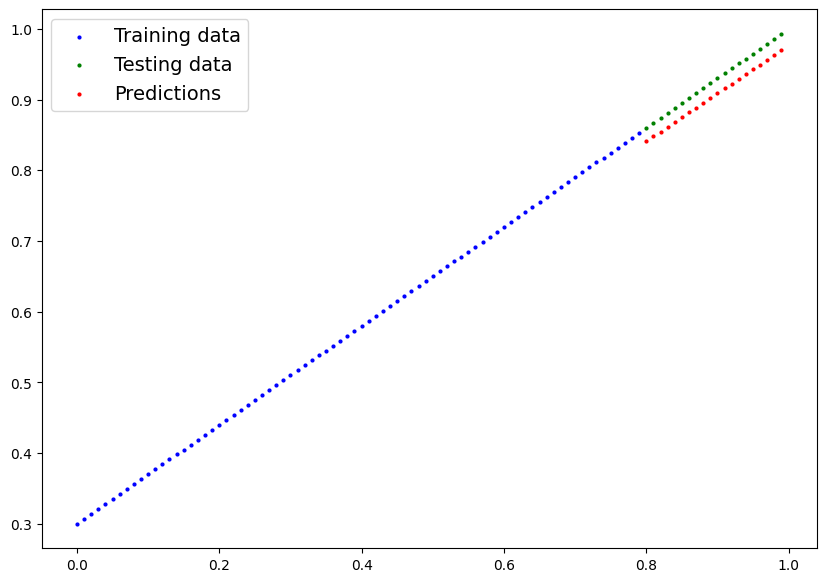

In [56]:
model_2.eval()
with torch.inference_mode():
  y_preds=model_2(X_test_regression)

plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

the missing piece: non-linearity

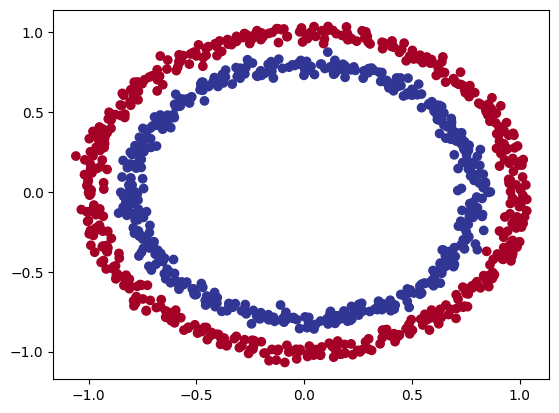

In [57]:
#recreating non-linear data(red and blue circles)

import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
n_samples=1000
X,y=make_circles(n_samples,
                 noise =0.03,
                 random_state=42)
plt.scatter(X[:,0],X[:,1],c=y ,cmap=plt.cm.RdYlBu)
plt.show()

In [58]:
import torch
from sklearn.model_selection import train_test_split
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
X_train[:5]

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        [-0.9666, -0.2256],
        [-0.1666,  0.7994]])

In [59]:
#building a model with non-linear activation function
from torch import nn
class CircleModelv2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1=nn.Linear(in_features=2,out_features=10)
    self.layer_2=nn.Linear(in_features=10,out_features=10)
    self.layer_3=nn.Linear(in_features=10,out_features=1)
    self.relu=nn.ReLU()

  def forward(self,x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3=CircleModelv2()
model_3.to(device)




CircleModelv2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [60]:
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(params=model_3.parameters(),lr=0.1)

In [61]:
torch.manual_seed(42)
X_train=X_train.to(device)
y_train=y_train.to(device)
X_test=X_test.to(device)
y_test=y_test.to(device)

epochs=2000

for epoch in range(epochs):
  model_3.train()
  y_logits=model_3(X_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits))
  loss=loss_fn(y_logits,y_train)
  acc=accuracy_fn(y_true=y_train,y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits=model_3(X_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))

    test_loss=loss_fn(test_logits,y_test)
    test_acc=accuracy_fn(y_true=y_test,y_pred=test_pred)

  if epoch%100==0:
    print(f"epoch no:{epoch},loss:{loss:5f},accuracy:{acc:2f}%,test loss:{test_loss:5f},test accuracy={test_acc:2f}%")





epoch no:0,loss:0.692946,accuracy:50.000000%,test loss:0.693188,test accuracy=50.000000%
epoch no:100,loss:0.691153,accuracy:52.875000%,test loss:0.691024,test accuracy=52.500000%
epoch no:200,loss:0.689774,accuracy:53.375000%,test loss:0.689396,test accuracy=55.000000%
epoch no:300,loss:0.687949,accuracy:53.000000%,test loss:0.687232,test accuracy=56.000000%
epoch no:400,loss:0.685168,accuracy:52.750000%,test loss:0.684115,test accuracy=56.500000%
epoch no:500,loss:0.681022,accuracy:52.750000%,test loss:0.679412,test accuracy=56.500000%
epoch no:600,loss:0.675149,accuracy:54.500000%,test loss:0.672851,test accuracy=56.000000%
epoch no:700,loss:0.666589,accuracy:58.375000%,test loss:0.663216,test accuracy=59.000000%
epoch no:800,loss:0.651596,accuracy:64.000000%,test loss:0.647569,test accuracy=67.500000%
epoch no:900,loss:0.623623,accuracy:74.000000%,test loss:0.621453,test accuracy=79.000000%
epoch no:1000,loss:0.568184,accuracy:87.750000%,test loss:0.573782,test accuracy=86.500000%


In [62]:
#evaluating model trained with non-linear activation function
model_3.eval()
with torch.inference_mode():
  y_preds=torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10],y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

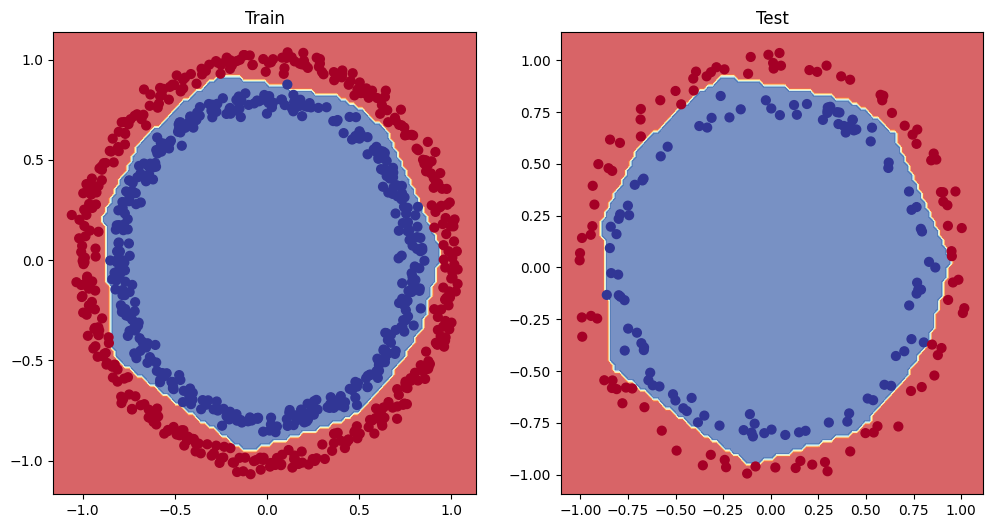

In [63]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3,X_train,y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3,X_test,y_test)


**Replicating non-linear activation functions**

 nueral network , rather than us telling what to learn,we give it to the tools to discover patterns in data and it tries to figure out the pattern on its own.

these tools are:
linear and non-linear data

In [64]:
#create a tensor
A=torch.arange(-10,10,1,dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

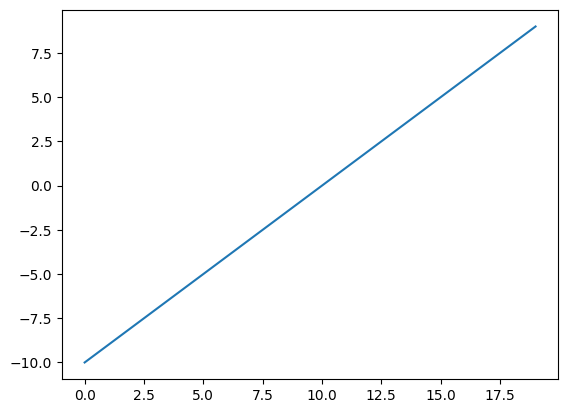

In [65]:
#visualize the tensor
plt.plot(A);


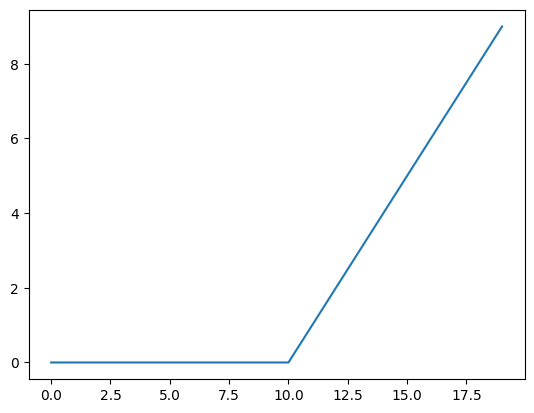

In [66]:
plt.plot(torch.relu(A))

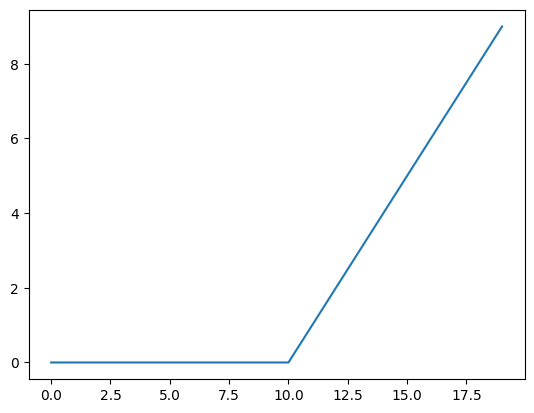

In [67]:
#relu function
def relu(x: torch.tensor) -> torch.tensor:
  return torch.maximum(torch.tensor(0),x)

relu(A)
plt.plot(relu(A))

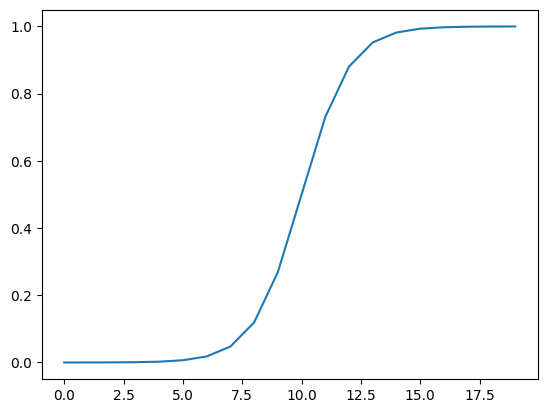

In [68]:
plt.plot(torch.sigmoid(A))

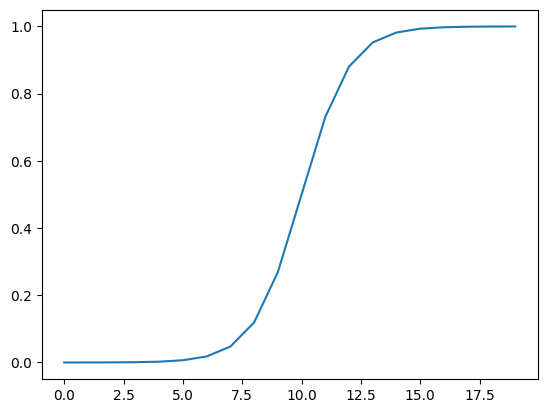

In [69]:
#sigmoid function
def sigmoid(x):
  return 1/(1+torch.exp(-x))


plt.plot(sigmoid(A))




Multi-class classification problem

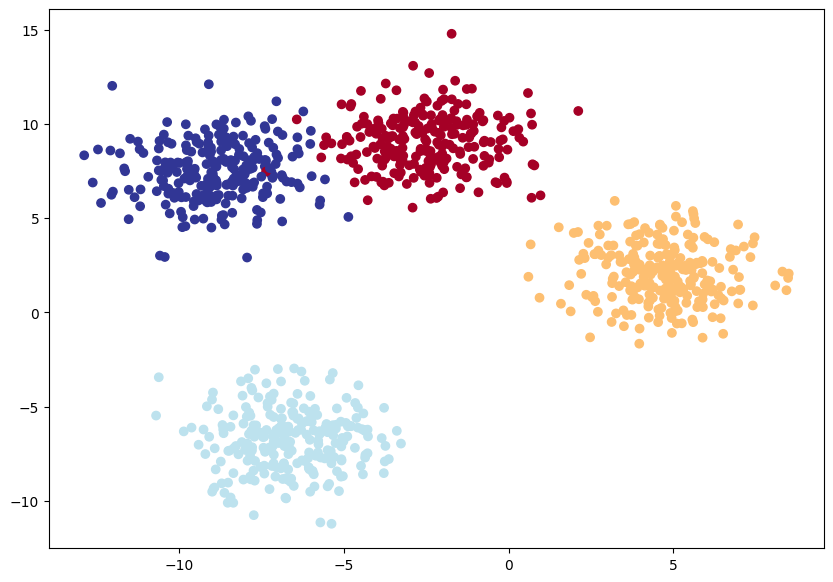

In [70]:
#creating a toy multiclass
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

#set the hyperparameters for data creation
NUM_CLASSES=4
NUM_FEATURES=2
RANDOM_SEED=42

#create multiclass data
X_blob,y_blob=make_blobs(n_samples=1000,
                         n_features=NUM_FEATURES,
                         centers=NUM_CLASSES,
                         cluster_std=1.5,    #give the clusters a little shake up
                         random_state=RANDOM_SEED)


#turn data into tensors
X_blob=torch.from_numpy(X_blob).type(torch.float)
y_blob=torch.from_numpy(y_blob).type(torch.LongTensor)

#split into training and test
X_blob_train,X_blob_test,y_blob_train,y_blob_test=train_test_split(X_blob,
                                                                   y_blob,
                                                                   test_size=0.2,
                                                                   random_state=RANDOM_SEED)


#plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu)

In [71]:
#building the multiclass classification model
device="cuda" if torch.cuda.is_available() else "cpu"
device

class BlobModel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units=8):
    super().__init__()
    self.linear_layer_stack=nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_features)
    )
  def forward(self,x):
    return self.linear_layer_stack(x)

model_4=BlobModel(input_features=2,
                  output_features=4,
                   hidden_units=8)
model_4.to(device)

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [72]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model_4.parameters(),lr=0.1)


In [73]:
#getting prediction probabilities for multi class pytorch model
model_4.eval()
with torch.inference_mode():
   y_preds_logits=model_4(X_blob_test.to(device))
   y_preds_probs=torch.softmax(y_preds_logits,dim=1)
   y_preds=torch.argmax(y_preds_probs,dim=1)

y_preds


tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

In [74]:
#training loop
torch.manual_seed(42)
epochs=100

X_blob_train=X_blob_train.to(device)
y_blob_train=y_blob_train.to(device)
X_blob_test=X_blob_test.to(device)
y_blob_test=y_blob_test.to(device)

for epoch in range(epochs):
  model_4.train()
  y_logits=model_4(X_blob_train).squeeze()
  y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)

  loss=loss_fn(y_logits,y_blob_train)
  acc=accuracy_fn(y_true=y_blob_train,
                  y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_4.eval()
  with torch.inference_mode():
    test_logits=model_4(X_blob_test).squeeze()
    test_pred=torch.softmax(test_logits,dim=1).argmax(dim=1)

    test_loss=loss_fn(test_logits,y_blob_test)
    test_acc=accuracy_fn(y_true=y_blob_test,y_pred=test_pred)

  if epoch%10==0:
    print(f"epoch no:{epoch},loss:{loss:5f},accuracy:{acc:2f}%,test loss:{test_loss:5f},test accuracy={test_acc:2f}%")

epoch no:0,loss:1.158827,accuracy:40.375000%,test loss:1.075542,test accuracy=48.000000%
epoch no:10,loss:0.644755,accuracy:96.750000%,test loss:0.660687,test accuracy=97.500000%
epoch no:20,loss:0.425352,accuracy:98.500000%,test loss:0.430741,test accuracy=100.000000%
epoch no:30,loss:0.252942,accuracy:99.125000%,test loss:0.245076,test accuracy=99.500000%
epoch no:40,loss:0.112322,accuracy:99.250000%,test loss:0.102285,test accuracy=99.500000%
epoch no:50,loss:0.066265,accuracy:99.250000%,test loss:0.058475,test accuracy=99.500000%
epoch no:60,loss:0.050680,accuracy:99.250000%,test loss:0.042932,test accuracy=99.500000%
epoch no:70,loss:0.042997,accuracy:99.250000%,test loss:0.034910,test accuracy=99.500000%
epoch no:80,loss:0.038361,accuracy:99.250000%,test loss:0.029878,test accuracy=99.500000%
epoch no:90,loss:0.035248,accuracy:99.250000%,test loss:0.026627,test accuracy=99.500000%


In [75]:
model_4.eval()
with torch.inference_mode():
  y_pred_logits=model_4(X_blob_test).squeeze()
  y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)
y_pred

tensor([1, 0, 2, 2, 0, 0, 0, 1, 3, 0, 0, 0, 3, 2, 3, 2, 1, 1, 3, 2, 2, 2, 3, 1,
        3, 2, 3, 0, 1, 0, 0, 1, 1, 3, 0, 2, 2, 1, 1, 3, 1, 1, 2, 3, 3, 0, 0, 0,
        1, 0, 0, 0, 2, 0, 1, 1, 3, 0, 2, 2, 3, 1, 0, 2, 1, 3, 2, 2, 2, 1, 0, 2,
        3, 1, 1, 1, 2, 0, 0, 1, 2, 3, 1, 3, 3, 2, 3, 3, 2, 2, 1, 0, 0, 1, 2, 1,
        3, 1, 2, 1, 3, 3, 3, 0, 2, 1, 2, 3, 1, 1, 2, 0, 3, 3, 2, 3, 2, 0, 3, 2,
        0, 0, 2, 2, 0, 1, 2, 0, 3, 3, 2, 3, 2, 1, 3, 1, 1, 1, 1, 0, 0, 1, 0, 2,
        3, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 2, 2, 0, 0, 3, 0, 3, 0, 3, 0, 2, 0, 1,
        2, 2, 2, 3, 0, 1, 1, 0, 1, 2, 0, 3, 2, 1, 3, 2, 3, 0, 3, 1, 1, 2, 2, 2,
        2, 2, 2, 0, 3, 3, 2, 1, 1, 2, 3, 1, 0, 0, 1, 3, 0, 1, 3, 3, 2, 3, 3, 3,
        1, 0, 0, 1, 0, 3, 2, 1, 0, 3, 0, 0, 3, 1, 0, 1, 0, 2, 2, 0, 0, 3, 3, 2,
        0, 2, 0, 3, 1, 3, 0, 2, 2, 0, 1, 1, 0, 2, 1, 1, 1, 0, 1, 3, 1, 1, 0, 2,
        2, 3, 1, 0, 1, 2, 3, 1, 2, 0, 3, 1, 3, 3, 3, 0, 3, 3, 3, 2, 3, 3, 1, 0,
        2, 2, 2, 2, 3, 1, 2, 2, 0, 2, 3,

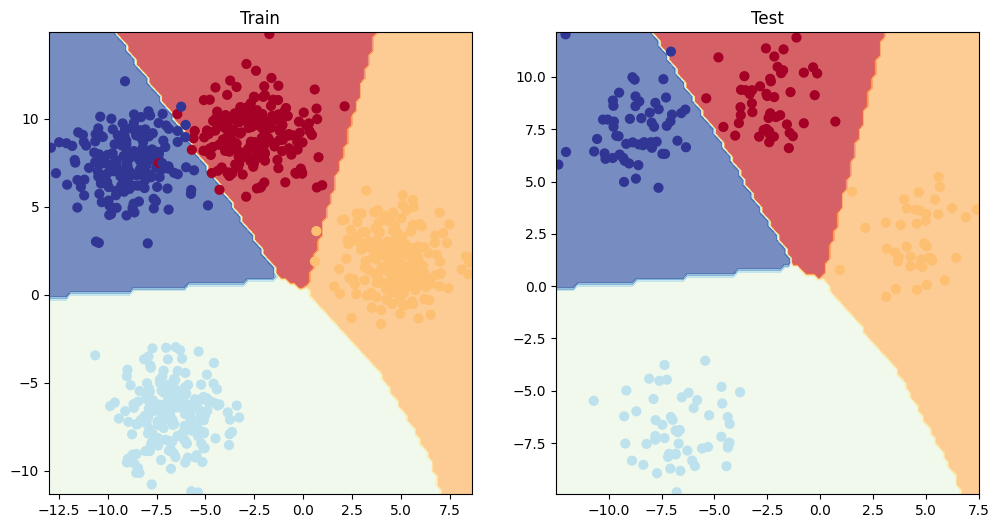

In [76]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4,X_blob_train,y_blob_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4,X_blob_test,y_blob_test)

 📊 Classification Metrics (Quick Revision)

---

 ✅ 1. Accuracy

**Definition:**  
Proportion of total correct predictions out of all predictions.

**Formula:**  
\[
{Accuracy} = {TP + TN}/{TP + TN + FP + FN}
\]

---
 🎯 2. Precision

**Definition:**  
Out of all predicted positives, how many are actually positive?

**Formula:**  
\[
{Precision} = {TP}/{TP + FP}
\]

---

 🔁 3. Recall (Sensitivity or True Positive Rate)

**Definition:**  
Out of all actual positives, how many did we correctly predict?

**Formula:**  
\[
 {Recall} = {TP}/{TP + FN}
\]

---

 ⚖️ 4. F1 Score

**Definition:**  
Harmonic mean of Precision and Recall. Balances the two.

**Formula:**  
\[
{F1 Score} = 2 {Precision * Recall} / {Precision} + {Recall}
\]

---

 📉 5. Confusion Matrix

**Definition:**  
Matrix showing actual vs. predicted classifications.

\[
\begin{bmatrix}
\text{TP} & \text{FP} \\
\text{FN} & \text{TN}
\end{bmatrix}
\]

- **TP**: True Positive  
- **FP**: False Positive  
- **FN**: False Negative  
- **TN**: True Negative  

---
 📄 6. Classification Report

**Definition:**  
A full report summarizing Precision, Recall, F1-score, and Support per class.

**Includes:**  
- Precision  
- Recall  
- F1-score  
- Support (no. of actual occurrences of each class)
.


In [77]:
pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [78]:
from torchmetrics import Accuracy
torchmetric_accuracy=Accuracy(task="multiclass",num_classes=4).to(device)
torchmetric_accuracy(test_pred,y_blob_test)

tensor(0.9950, device='cuda:0')

Exercises

Make a binary classification dataset with Scikit-Learn's make_moons() function.

For consistency, the dataset should have 1000 samples and a random_state=42.

Turn the data into PyTorch tensors. Split the data into training and test sets using train_test_split with 80% training and 20% testing.

In [79]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [80]:
X,y=make_moons(n_samples=1000,noise=0.2,random_state=42)
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
print(len(X_train),len(X_test),len(y_train),len(y_test))
print(X_train.shape)
print(X_train.dtype)

800 200 800 200
torch.Size([800, 2])
torch.float32


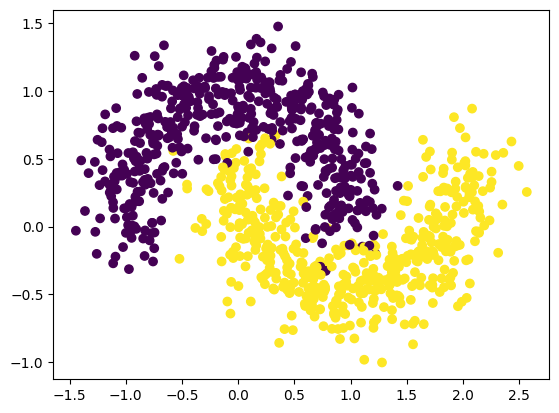

In [81]:
#viisulize the dataset
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y)

Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.

Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [82]:

class Moonmodel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1=nn.Linear(in_features=2,out_features=8)
    self.relu=nn.ReLU()
    self.layer_2=nn.Linear(in_features=8,out_features=8)
    self.relu=nn.ReLU()
    self.layer_3=nn.Linear(in_features=8,out_features=1)


  def forward(self,x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

device="cuda" if torch.cuda.is_available() else "cpu"
device

model=Moonmodel().to(device)


Setup a binary classification compatible loss function and optimizer to use when training the model.

In [83]:
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(params=model.parameters(),lr=0.1)

Create a training and testing loop to fit the model you created in 2 to the data you created in 1.

To measure model accuracy, you can create your own accuracy function or use the accuracy function in TorchMetrics.

Train the model for long enough for it to reach over 96% accuracy.

The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [84]:
epochs=1000
X_train=X_train.to(device)
y_train=y_train.to(device)
X_test=X_test.to(device)
y_test=y_test.to(device)
for epoch in range(epochs):
    model.train()
    y_logits=model(X_train).squeeze()
    y_pred=torch.round(torch.sigmoid(y_logits))
    loss=loss_fn(y_logits,y_train)
    acc=accuracy_fn(y_true=y_train,y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
      test_logits=model(X_test).squeeze()
      test_pred=torch.round(torch.sigmoid(test_logits))
      test_loss=loss_fn(test_logits,y_test)
      test_acc=accuracy_fn(y_true=y_test,y_pred=test_pred)

    if epoch%10==0:
      print(f"epoch no:{epoch},loss:{loss:5f},accuracy:{acc:2f}%,test loss:{test_loss:5f},test accuracy={test_acc:2f}%")




epoch no:0,loss:0.712204,accuracy:50.000000%,test loss:0.705024,test accuracy=50.000000%
epoch no:10,loss:0.691082,accuracy:57.250000%,test loss:0.688575,test accuracy=61.500000%
epoch no:20,loss:0.679771,accuracy:80.125000%,test loss:0.679084,test accuracy=81.500000%
epoch no:30,loss:0.667285,accuracy:83.375000%,test loss:0.667928,test accuracy=79.500000%
epoch no:40,loss:0.649007,accuracy:82.250000%,test loss:0.651141,test accuracy=79.000000%
epoch no:50,loss:0.621500,accuracy:82.000000%,test loss:0.625477,test accuracy=79.000000%
epoch no:60,loss:0.582218,accuracy:81.875000%,test loss:0.588549,test accuracy=78.500000%
epoch no:70,loss:0.531623,accuracy:82.750000%,test loss:0.540795,test accuracy=80.000000%
epoch no:80,loss:0.476132,accuracy:83.250000%,test loss:0.487772,test accuracy=81.000000%
epoch no:90,loss:0.425380,accuracy:83.750000%,test loss:0.438338,test accuracy=80.500000%
epoch no:100,loss:0.386181,accuracy:84.250000%,test loss:0.399235,test accuracy=81.500000%
epoch no:1

Make predictions with your trained model and plot them using the plot_decision_boundary() function created in this notebook.

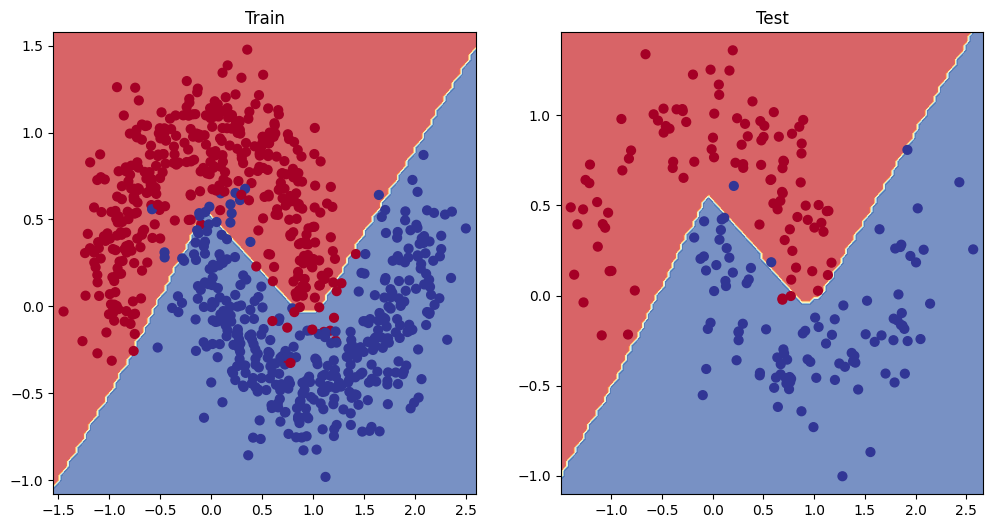

In [85]:
model.eval()
with torch.inference_mode():
  y_preds=torch.round(torch.sigmoid(model(X_test))).squeeze()

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model,X_train,y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model,X_test,y_test)

Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch

In [86]:
B=torch.arange(-10,10,0.2)
B

tensor([-1.0000e+01, -9.8000e+00, -9.6000e+00, -9.4000e+00, -9.2000e+00,
        -9.0000e+00, -8.8000e+00, -8.6000e+00, -8.4000e+00, -8.2000e+00,
        -8.0000e+00, -7.8000e+00, -7.6000e+00, -7.4000e+00, -7.2000e+00,
        -7.0000e+00, -6.8000e+00, -6.6000e+00, -6.4000e+00, -6.2000e+00,
        -6.0000e+00, -5.8000e+00, -5.6000e+00, -5.4000e+00, -5.2000e+00,
        -5.0000e+00, -4.8000e+00, -4.6000e+00, -4.4000e+00, -4.2000e+00,
        -4.0000e+00, -3.8000e+00, -3.6000e+00, -3.4000e+00, -3.2000e+00,
        -3.0000e+00, -2.8000e+00, -2.6000e+00, -2.4000e+00, -2.2000e+00,
        -2.0000e+00, -1.8000e+00, -1.6000e+00, -1.4000e+00, -1.2000e+00,
        -1.0000e+00, -8.0000e-01, -6.0000e-01, -4.0000e-01, -2.0000e-01,
        -5.9605e-09,  2.0000e-01,  4.0000e-01,  6.0000e-01,  8.0000e-01,
         1.0000e+00,  1.2000e+00,  1.4000e+00,  1.6000e+00,  1.8000e+00,
         2.0000e+00,  2.2000e+00,  2.4000e+00,  2.6000e+00,  2.8000e+00,
         3.0000e+00,  3.2000e+00,  3.4000e+00,  3.6

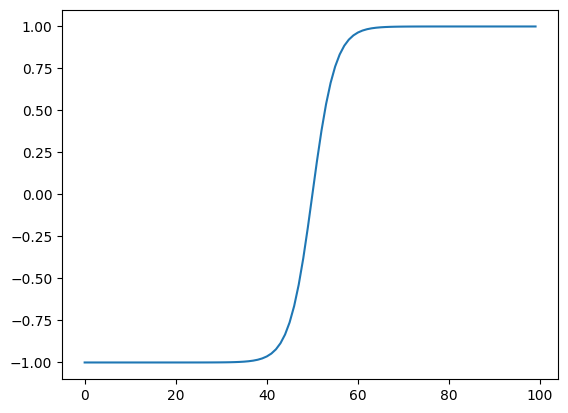

In [87]:
plt.plot(torch.tanh(B))
plt.show()

The hyperbolic tangent function is defined as:

$$
\tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}
$$

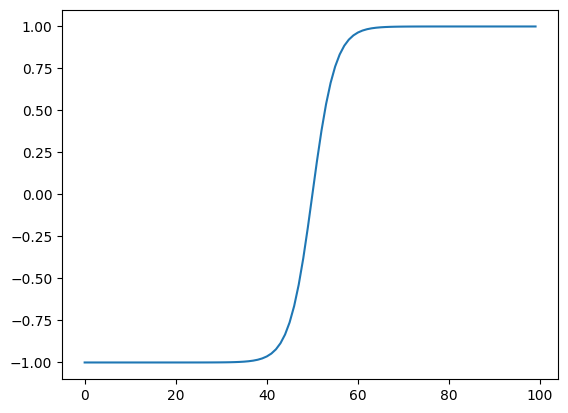

In [88]:
def tanhz(x:torch.tensor) ->torch.tensor:
  return (torch.exp(x)-torch.exp(-x))/(torch.exp(x)+torch.exp(-x))

plt.plot(tanhz(B))

Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).

Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).

Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).

Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).

Plot the decision boundaries on the spirals dataset from your model predictions, the plot_decision_boundary() function should work for this dataset too.

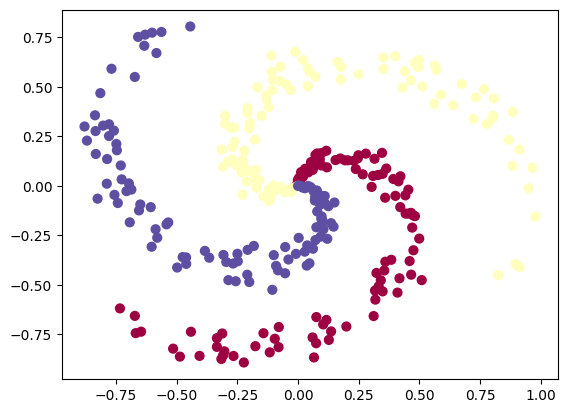

In [161]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [162]:
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()


In [163]:

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
print(len(X_train),len(X_test),len(y_train),len(y_test))
print(X_train.shape)
print(X_train.dtype)

240 60 240 60
torch.Size([240, 2])
torch.float32


In [167]:
class Spiralmodel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1=nn.Linear(in_features=2,out_features=8)

    self.layer_2=nn.Linear(in_features=8,out_features=8)

    self.layer_3=nn.Linear(in_features=8,out_features=3)

    self.relu=nn.ReLU()


  def forward(self,x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

device="cuda" if torch.cuda.is_available() else "cpu"
device

model_8=Spiralmodel().to(device)

In [168]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_8.parameters(),lr=0.02)

In [170]:
#training loop
torch.manual_seed(42)
epochs=1000

X_train=X_train.to(device)
y_train=y_train.to(device)
X_test=X_test.to(device)
y_test=y_test.to(device)

for epoch in range(epochs):
  model_8.train()
  y_logits=model_8(X_train).squeeze()
  y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)

  loss=loss_fn(y_logits,y_train)
  acc=accuracy_fn(y_true=y_train,
                  y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_8.eval()
  with torch.inference_mode():
    test_logits=model_8(X_test).squeeze()
    test_pred=torch.softmax(test_logits,dim=1).argmax(dim=1)

    test_loss=loss_fn(test_logits,y_test)
    test_acc=accuracy_fn(y_true=y_test,y_pred=test_pred)

  if epoch%10==0:
    print(f"epoch no:{epoch},loss:{loss:5f},accuracy:{acc:2f}%,test loss:{test_loss:5f},test accuracy={test_acc:2f}%")

epoch no:0,loss:1.090876,accuracy:35.416667%,test loss:1.076443,test accuracy=43.333333%
epoch no:10,loss:0.970576,accuracy:52.916667%,test loss:1.000172,test accuracy=40.000000%
epoch no:20,loss:0.844339,accuracy:54.166667%,test loss:0.869834,test accuracy=53.333333%
epoch no:30,loss:0.729185,accuracy:60.000000%,test loss:0.766515,test accuracy=63.333333%
epoch no:40,loss:0.641411,accuracy:64.583333%,test loss:0.699334,test accuracy=60.000000%
epoch no:50,loss:0.562360,accuracy:65.416667%,test loss:0.638786,test accuracy=61.666667%
epoch no:60,loss:0.499378,accuracy:70.416667%,test loss:0.573618,test accuracy=66.666667%
epoch no:70,loss:0.440989,accuracy:75.833333%,test loss:0.495867,test accuracy=71.666667%
epoch no:80,loss:0.385311,accuracy:80.416667%,test loss:0.427706,test accuracy=75.000000%
epoch no:90,loss:0.335873,accuracy:85.416667%,test loss:0.364569,test accuracy=81.666667%
epoch no:100,loss:0.289814,accuracy:88.750000%,test loss:0.306245,test accuracy=83.333333%
epoch no:1

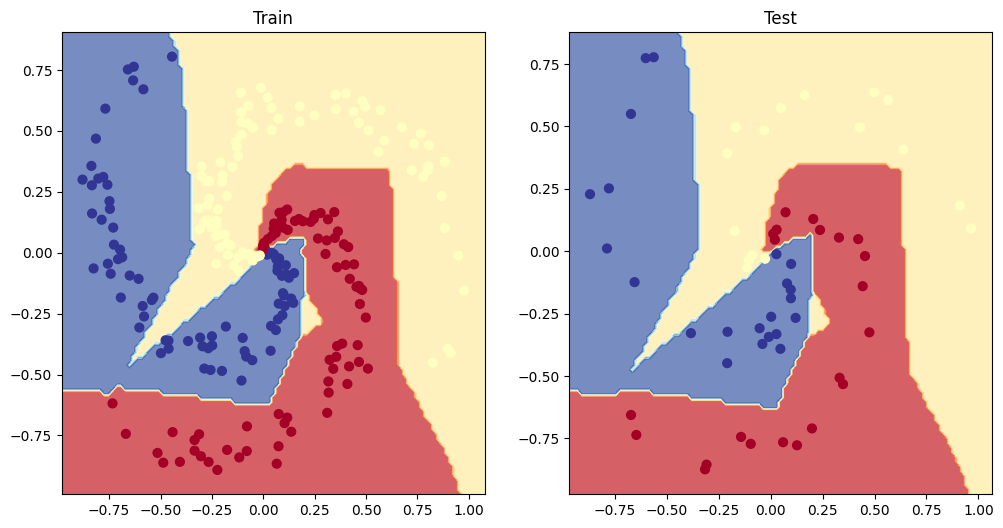

In [172]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_8, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_8, X_test, y_test)